# Plots

This notebook purpose is to replicate the plots in the paper. To generate them, simply run each cell.

Run information was gethered via Weights & Biases and is therefore linked to an account. Therefore, we include all run logs necessary to replicate the plots without requiring Weights & Biases.

### Setting up the environment

In [3]:
import pandas as pd
import wandb
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('..')


In [4]:
wandb_folder = "data/wandb_data"
data_folder = "data/sst2"
model = "ham_icy-sweep-6"

entity, project = "ukp-quantum", "quantum-sent-emb-v2"
#             # RNN,          LSTM,     MLP         BOW,       CIRC,        HAM
sweep_ids = ['kksuq6f5', '1fny4c0i', '4bn0i377', 'lhj7yisr', 'uu1ja94q', 'mc936q6f']
prefix = 'exp'

#              'CIRC'      'HAM'        PEFFBIAS,   NOBIAS,     SENTIN,    CIRCHAM  
# sweep_ids = ['uu1ja94q', 'mc936q6f', 'no6jb1kh', '4djpaeiw', 'r7c17aw5', 'umim1d63']
# prefix = 'ablation'

### Fetching data from `wandb`

This block generates two files:
- `{prefix}_run_configs.csv`: Contains run configuration information useful for aggregation purposes
- `{prefix}_history.csv`: Contains the run history of every run listed in `sweep_ids`

In [3]:
api = wandb.Api()

summary_list, config_list = [], [] 
run_name_list, run_id_list = [], []
sweep_name_list, sweep_id_list = [], []
history_list = []

for sweep_id in tqdm(sweep_ids):
    sweep = api.sweep(f"{entity}/{project}/sweeps/{sweep_id}")

    sweep_name_list += [sweep.name] * len(sweep.runs)
    sweep_id_list += [sweep_id] * len(sweep.runs)

    runs = sweep.runs
    for run in runs:
        # .summary contains output keys/values for
        # metrics such as accuracy.
        #  We call ._json_dict to omit large files
        # summary_list.append(run.summary._json_dict)
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

        # .name is the human-readable name of the run.
        run_name_list.append(run.name)
        run_id_list.append(run.id)

        # Put history in csv file
        history = run.scan_history()
        history_df = pd.DataFrame(history)
        history_df['run_id'] = run.id
        history_df = history_df[history_df['epoch'].notna()]
        history_list.append(history_df)

runs_df = pd.DataFrame(
    {"name": run_name_list, "id": run_id_list,
     "sweep_name": sweep_name_list, "sweep_id": sweep_id_list}
)
config_df = pd.DataFrame(config_list)
# print(summary_list)
summary_df = pd.DataFrame([sl for sl in summary_list])


info_df = pd.concat([runs_df, summary_df, config_df], axis=1)
# Put runs in csv file
info_df.to_csv(f"{wandb_folder}/{prefix}_run_configs.csv")

history_df = pd.concat(history_list)
history_df.to_csv(f"{wandb_folder}/{prefix}_history.csv")
print("Done fetching data from wandb")

100%|██████████| 6/6 [08:57<00:00, 89.59s/it] 

Done fetching data from wandb


### Computing aggregates

This block reads the previous files and generates aggregate statistics

In [5]:
print('Final aggregates')
info_df = pd.read_csv(f"{wandb_folder}/{prefix}_run_configs.csv")

agg_df = info_df.groupby("sweep_id", as_index=False).agg({'sweep_name' : 'first', 'n_all_params': 'first',
                                  'dev accuracy': ['mean', 'std'], 'dev F1': ['mean', 'std'], 'dev loss': ['mean', 'std'],
                                  'train accuracy': ['mean', 'std'], 'train F1': ['mean', 'std'], 'loss': ['mean', 'std']})
agg_df.columns = ['sweep_id', 'sweep_name', 'n_all_params', 'dev accuracy_mean', 'dev accuracy_std', 'dev F1_mean', 'dev F1_std', 'dev loss_mean', 'dev loss_std',
                    'train accuracy_mean', 'train accuracy_std', 'train F1_mean', 'train F1_std', 'train loss_mean', 'train loss_std']
# Formats columns as mean +- std e.g. .739 +- .010 
agg_df['Train Accuracy'] = agg_df['train accuracy_mean'].round(3).astype(str) + '$\\pm$' + agg_df['train accuracy_std'].round(3).astype(str)
agg_df['Train F1'] = agg_df['train F1_mean'].round(3).astype(str) + '$\\pm$' + agg_df['train F1_std'].round(3).astype(str)
# agg_df['Train Loss'] = agg_df['train loss_mean'].round(3).astype(str) + '$\\pm$' + agg_df['train loss_std'].round(3).astype(str)
agg_df['Dev Accuracy'] = agg_df['dev accuracy_mean'].round(3).astype(str) + '$\\pm$' + agg_df['dev accuracy_std'].round(3).astype(str)
agg_df['Dev F1'] = agg_df['dev F1_mean'].round(3).astype(str) + '$\\pm$' + agg_df['dev F1_std'].round(3).astype(str)
# agg_df['Dev Loss'] = agg_df['dev loss_mean'].round(3).astype(str) + '$\\pm$' + agg_df['dev loss_std'].round(3).astype(str)

# Drop columns
agg_df.drop(['sweep_id', 'train loss_mean', 'train loss_std', 'train accuracy_mean', 'train accuracy_std', 'train F1_mean', 
             'train F1_std', 'dev loss_mean', 'dev loss_std', 'dev accuracy_mean', 'dev accuracy_std', 'dev F1_mean', 'dev F1_std'], axis=1, inplace=True)
# Print to latex
latex_table = agg_df.to_latex(f"{wandb_folder}/{prefix}_agg_runs.tex", index=False,
                column_format="lcccccc")
print(latex_table)

Final aggregates
None


### Plotting

This block generates history plots using the files created earlier

In [3]:
### Generate plots ###
print('History plots')
plot_folder = 'plots'
history_df = pd.read_csv(f"{wandb_folder}/{prefix}_history.csv")
# history_df['dev loss'] = history_df['dev loss'].round(3)
info_df = pd.read_csv(f"{wandb_folder}/{prefix}_run_configs.csv")
info_df['sweep_name'] = info_df['sweep_name'].map({
    'sentemb_rnn_run': 'RNN',
    'sentemb_lstm_run': 'LSTM',
    'sentemb_mlp_run': 'MLP',
    'sentemb_bow_run': 'BOW',
    'sentemb_circ_run': 'CIRC',
    'sentemb_ham_run': 'HAM',
    'sentemb_ablation_circham_run': 'CIRC HAM',
    'sentemb_ablation_peffbias_run': 'PEFF BIAS',
    'sentemb_ablation_nobias_run': 'NO BIAS',
    'sentemb_ablation_sentin_run': 'SENT IN',
})
info_df = info_df[['id', 'sweep_name']]

# Join history with run info on run_id
history_df = history_df.merge(info_df, left_on='run_id', right_on='id',suffixes=('', ''))
history_df['epoch'] = history_df['epoch'] + 1

# Plot history
def plot(history_df, title, metric, ylabel, prefix, filename):
    green_theme = sns.axes_style('darkgrid')
    green_theme['axes.facecolor'] = '#EAF2EA'
    plt.figure(figsize=(12, 8))
    sns.set_theme(style=green_theme, font_scale=2.5)
    g = sns.lineplot(data=history_df, x='epoch', y=metric, hue='sweep_name', 
                     errorbar='sd')
    g.legend_.set_title('Model')
    if metric == 'dev loss' or metric == 'loss':
        plt.ticklabel_format(style='sci', axis='y', scilimits=(-3,-3))

    plt.legend(fontsize=18)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout() 
    plt.savefig(f"{plot_folder}/{prefix}_{filename}.pdf")
    plt.close()

metrics = ['loss', 'train accuracy', 'train F1', 'dev loss', 'dev accuracy', 'dev F1']
ylabels = ['Train loss', 'Train accuracy', 'Train F1', 'Dev loss', 'Dev accuracy', 'Dev F1']
filenames = ['train_loss', 'train_accuracy', 'train_f1', 'dev_loss', 'dev_accuracy', 'dev_f1']
titles = ['Train loss', 'Train accuracy', 'Train F1', 'Dev loss', 'Dev accuracy', 'Dev F1']
for title, metric, ylabel, filename in zip(titles, metrics, ylabels, filenames):
    plot(history_df, title, metric, ylabel, prefix, filename)

print('Done plotting history')

History plots
Done plotting history


This block generates the plot for performance drop when decomposing the Hamiltonian

History plots


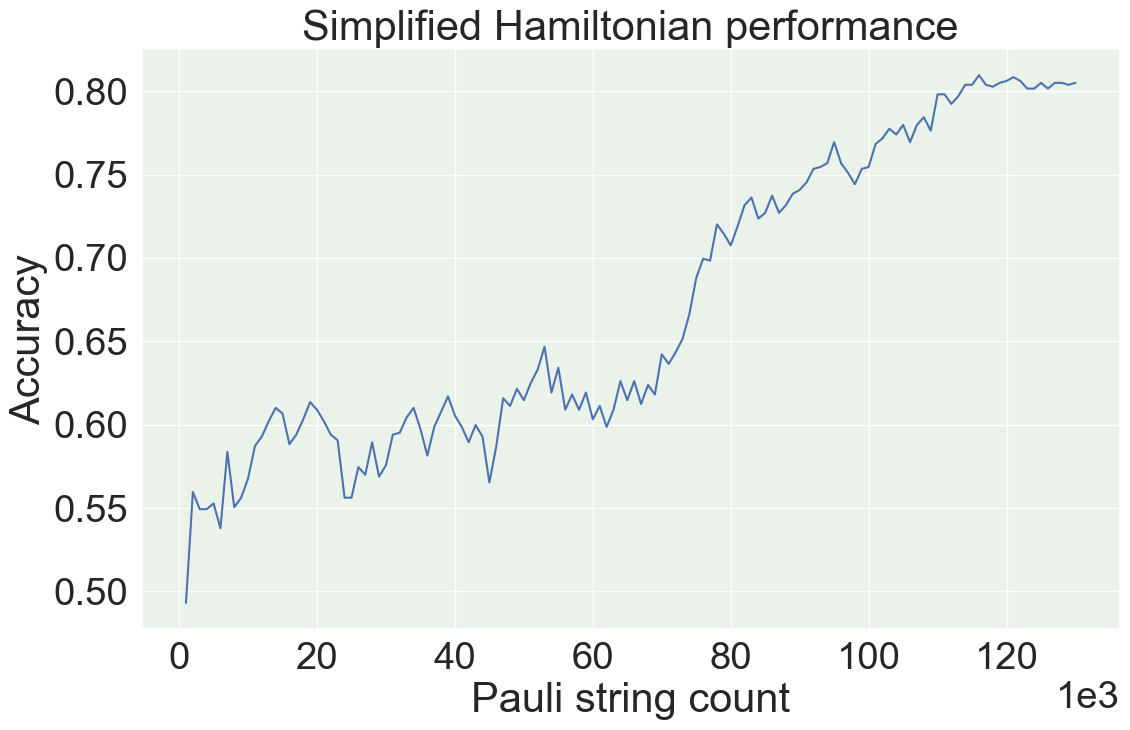

In [12]:
from matplotlib.ticker import StrMethodFormatter


print('History plots')
plot_folder = 'plots'
dec_df = pd.read_csv(f"{data_folder}/model_{model}.pth_decomposed_metrics_good.csv")

# Plot degradation
def plot(dec_df, title, metric, ylabel, model, filename):
    green_theme = sns.axes_style('darkgrid')
    green_theme['axes.facecolor'] = '#EAF2EA'
    plt.figure(figsize=(12, 8))
    sns.set_theme(style=green_theme, font_scale=2.5)
    g = sns.lineplot(data=dec_df, x='string_count', y=metric, 
                     errorbar=None)
    # g.legend_.set_title('Model')

    # Set x-axis label format as 120k instead of 120000
    # g.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}k'))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(3,3))

    plt.xlabel('Pauli string count')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout() 
    plt.savefig(f"{plot_folder}/{model}_dec_drop_{filename}.pdf")
    plt.show()
    plt.close()

plot(dec_df, 'Simplified Hamiltonian performance', 'accuracy', 'Accuracy', model, 'accuracy')
